In [26]:
pip install wordcloud

StatementMeta(, ff1aa0d8-7214-4df7-a009-579a680a8ea6, 28, Finished, Available, Finished)

Note: you may need to restart the kernel to use updated packages.


In [27]:
import pandas as pd
import scipy as sp
import numpy as np
import pyarrow.parquet as pq
import pyarrow as pa
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import operator
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings("ignore")

StatementMeta(, ff1aa0d8-7214-4df7-a009-579a680a8ea6, 29, Finished, Available, Finished)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
# Load data into pandas DataFrame from "/lakehouse/default/Files/Final_data/ML/ML_model.parquet"
df_model = pd.read_parquet("/lakehouse/default/Files/Final_data/ML/ML_model.parquet")
df_model


StatementMeta(, ff1aa0d8-7214-4df7-a009-579a680a8ea6, 30, Finished, Available, Finished)

,Item_id,Item_name,Genres,Rating,User_id,Review,Ranking
0,10,Counter-Strike,Action,E,76561197970982479,Simple yet with great replayability. In my opi...,5
1,10,Counter-Strike,Action,E,js41637,I know what you think when you see this title ...,5
2,10,Counter-Strike,Action,E,doctr,This game... is so fun. The fight sequences ha...,5
3,10,Counter-Strike,Action,E,76561198089393905,"Killed the Emperor, nobody cared and got away ...",1
4,10,Counter-Strike,Action,E,WeiEDKrSat,es la rajaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...,3
...,...,...,...,...,...,...,...
4241294,528660,Spin Rush,Casual,E,thugnificent,"""I'm drunk, very very drunk"" cuz i voted this ...",1
4241295,528660,Spin Rush,Indie,E,SirexPower,Это даже не игра.От того что вы что нажимаете ...,2
4241296,528660,Spin Rush,Indie,E,thugnificent,"""I'm drunk, very very drunk"" cuz i voted this ...",1
4241297,530720,Solitaire Royale,Casual,E,mayshowganmore,THE BEST FPS GAME!!!!!,3


In [29]:
# Primero, agrupa por 'Item_name' y aplica la agregación deseada
df_sampled = (
    df_model.groupby('Item_name')
    .agg({
        'Genres': lambda x: ', '.join(x.unique()),   # Combine genres into a comma-separated string
        'Rating': 'first',                           # Take the first rating (assuming it doesn't change)
        'Ranking': 'mean',                           # Calculate the average ranking
    })
    .reset_index()
)

# Une df_sampled con df_model para conservar las demás columnas
df_sampled = pd.merge(df_model[['Item_name', 'Item_id', 'User_id', 'Review']], df_sampled, on='Item_name', how='left')
df_sampled.drop_duplicates().reset_index()

StatementMeta(, ff1aa0d8-7214-4df7-a009-579a680a8ea6, 31, Finished, Available, Finished)

,index,Item_name,Item_id,User_id,Review,Genres,Rating,Ranking
0,0,Counter-Strike,10,76561197970982479,Simple yet with great replayability. In my opi...,Action,E,3.654011
1,1,Counter-Strike,10,js41637,I know what you think when you see this title ...,Action,E,3.654011
2,2,Counter-Strike,10,doctr,This game... is so fun. The fight sequences ha...,Action,E,3.654011
3,3,Counter-Strike,10,76561198089393905,"Killed the Emperor, nobody cared and got away ...",Action,E,3.654011
4,4,Counter-Strike,10,WeiEDKrSat,es la rajaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...,Action,E,3.654011
...,...,...,...,...,...,...,...,...
1449064,4241267,Found,528580,mayshowganmore,THE BEST FPS GAME!!!!!,"Adventure, Casual, Free to Play, Indie, Early ...",E,4.000000
1449065,4241268,Found,528580,REBAS_AS_F-T,Il est vraiment excellent !!! Faut y jouer pou...,"Adventure, Casual, Free to Play, Indie, Early ...",E,4.000000
1449066,4241291,Spin Rush,528660,SirexPower,Это даже не игра.От того что вы что нажимаете ...,"Action, Casual, Indie",E,1.500000
1449067,4241292,Spin Rush,528660,thugnificent,"""I'm drunk, very very drunk"" cuz i voted this ...","Action, Casual, Indie",E,1.500000


In [30]:
# Función para seleccionar usuarios
def sample_users(df):
    def select_users(users):
        unique_users = users.drop_duplicates()
        # Si hay menos de 5 usuarios, retorna todos; si no, selecciona 5 aleatoriamente
        if len(unique_users) <= 150:
            return unique_users
        else:
            return unique_users.sample(n=150, random_state=1)

    # Seleccionar usuarios según la lógica definida
    sampled_users_per_item = (
        df.groupby('Item_name')['User_id']
        .apply(select_users)
        .reset_index()
    )

    # Merge con el DataFrame original para obtener los comentarios de los usuarios seleccionados
    df_mf = df.merge(sampled_users_per_item, on=['Item_name', 'User_id'], how='inner')
    return df_mf

# Aplica la función a df_sampled
df_mf = sample_users(df_sampled)
df_mf


StatementMeta(, ff1aa0d8-7214-4df7-a009-579a680a8ea6, 32, Finished, Available, Finished)

,Item_name,Item_id,User_id,Review,Genres,Rating,Ranking,level_1
0,Counter-Strike,10,VVillis,My character is a Jew named ♥♥♥♥♥♥♥♥♥ that is ...,Action,E,3.654011,6
1,Counter-Strike,10,Nozomikat,My childhood game has finally gotten onto stea...,Action,E,3.654011,13
2,Counter-Strike,10,EizanAratoFujimaki,ADVERTENCIA:Este Análisis contiene posibles Sp...,Action,E,3.654011,19
3,Counter-Strike,10,Br0wni3,is really good game but toxic community,Action,E,3.654011,79
4,Counter-Strike,10,76561198051215704,Ninja bears and KOSers...........................,Action,E,3.654011,93
...,...,...,...,...,...,...,...,...
1052949,Spin Rush,528660,thugnificent,"""I'm drunk, very very drunk"" cuz i voted this ...","Action, Casual, Indie",E,1.500000,4241292
1052950,Spin Rush,528660,thugnificent,"""I'm drunk, very very drunk"" cuz i voted this ...","Action, Casual, Indie",E,1.500000,4241292
1052951,Spin Rush,528660,thugnificent,"""I'm drunk, very very drunk"" cuz i voted this ...","Action, Casual, Indie",E,1.500000,4241292
1052952,Solitaire Royale,530720,mayshowganmore,THE BEST FPS GAME!!!!!,"Casual, Indie",E,3.000000,4241297


## User to Item recomendation

In [31]:
df_mod_user = df_model[['User_id', 'Item_name', 'Ranking']]
df_mod_user.drop_duplicates(inplace=True)
df_mod_user

StatementMeta(, ff1aa0d8-7214-4df7-a009-579a680a8ea6, 33, Finished, Available, Finished)

,User_id,Item_name,Ranking
0,76561197970982479,Counter-Strike,5
1,js41637,Counter-Strike,5
2,doctr,Counter-Strike,5
3,76561198089393905,Counter-Strike,1
4,WeiEDKrSat,Counter-Strike,3
...,...,...,...
4241267,mayshowganmore,Found,3
4241268,REBAS_AS_F-T,Found,5
4241291,SirexPower,Spin Rush,2
4241292,thugnificent,Spin Rush,1


In [32]:
u_matrix = df_mod_user.pivot_table(index=['User_id'], columns=['Item_name'], values='Ranking')
u_matrix

StatementMeta(, ff1aa0d8-7214-4df7-a009-579a680a8ea6, 34, Finished, Available, Finished)

Item_name,! That Bastard Is Trying To Steal Our Gold !,"""Glow Ball"" - The billiard puzzle game",#SelfieTennis,$1 Ride,001 Game Creator,0RBITALIS,1 Moment Of Time: Silentville,"1,000 Heads Among the Trees",10 Minute Tower,10 Second Ninja,...,resident evil 4 / biohazard 4,room13,rymdkapsel,sZone-Online,samurai_jazz,simian.interface++,stratO,the static speaks my name,theBlu,侠客风云传(Tale of Wuxia)
User_id,,,,,,,,,,,,,,,,,,,,,
--000--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
--ace--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--ionex--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-2SV-vuLB-Kg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-Beave-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zwanzigdrei,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zy0705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zynxgameth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
random_rows = 4000
u_matrix_sample = u_matrix.sample(n=random_rows, random_state=42)

StatementMeta(, ff1aa0d8-7214-4df7-a009-579a680a8ea6, 35, Finished, Available, Finished)

In [34]:
scaler = MinMaxScaler()
umatrix_norm = pd.DataFrame(scaler.fit_transform(u_matrix_sample), columns=u_matrix_sample.columns, index=u_matrix_sample.index)

# The columns that contain only zero or have no rating are deleted, the gaps are filled with 0.
umatrix_norm.fillna(0, inplace=True)
umatrix_norm = umatrix_norm.T
umatrix_norm = umatrix_norm.loc[:, (umatrix_norm != 0).any(axis=0)]
umatrix_norm

StatementMeta(, ff1aa0d8-7214-4df7-a009-579a680a8ea6, 36, Finished, Available, Finished)

User_id,Jacler,theo8396,MatusPocus,75791513,76561198091085055,76561198078752334,pizzaman12,76561198062646700,76561198110065267,Thorinnnnnnnnnn,...,76561198067716040,44290,Deflaborator,Strobies,SurfChicken,hughloscher,76561198093080426,luiz91457,Packmanman,76561198075883349
Item_name,,,,,,,,,,,,,,,,,,,,,
! That Bastard Is Trying To Steal Our Gold !,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""Glow Ball"" - The billiard puzzle game",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#SelfieTennis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
$1 Ride,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001 Game Creator,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
simian.interface++,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
stratO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
the static speaks my name,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
um_sparse = sp.sparse.csr_matrix(umatrix_norm.values)
um_sparse

StatementMeta(, ff1aa0d8-7214-4df7-a009-579a680a8ea6, 37, Finished, Available, Finished)

<7093x3178 sparse matrix of type '<class 'numpy.float64'>'
	with 210640 stored elements in Compressed Sparse Row format>

In [36]:
um_sparse_normalized = normalize(um_sparse)

StatementMeta(, ff1aa0d8-7214-4df7-a009-579a680a8ea6, 38, Finished, Available, Finished)

In [37]:
user_similarity = cosine_similarity(um_sparse_normalized.T)

StatementMeta(, ff1aa0d8-7214-4df7-a009-579a680a8ea6, 39, Finished, Available, Finished)

In [38]:
user_sim_df = pd.DataFrame(user_similarity, index = umatrix_norm.columns, columns = umatrix_norm.columns)
user_sim_df

StatementMeta(, ff1aa0d8-7214-4df7-a009-579a680a8ea6, 40, Finished, Available, Finished)

User_id,Jacler,theo8396,MatusPocus,75791513,76561198091085055,76561198078752334,pizzaman12,76561198062646700,76561198110065267,Thorinnnnnnnnnn,...,76561198067716040,44290,Deflaborator,Strobies,SurfChicken,hughloscher,76561198093080426,luiz91457,Packmanman,76561198075883349
User_id,,,,,,,,,,,,,,,,,,,,,
Jacler,1.000000,0.008929,0.040343,0.037882,0.007933,0.058760,0.018907,0.036861,0.018126,0.019954,...,0.038620,0.043013,0.107206,0.016105,0.038812,0.009662,0.030361,0.068661,0.030084,0.013204
theo8396,0.008929,1.000000,0.018117,0.008602,0.010625,0.000000,0.008029,0.064339,0.008503,0.039167,...,0.000000,0.000000,0.018347,0.009707,0.004540,0.033961,0.073182,0.021189,0.063798,0.031228
MatusPocus,0.040343,0.018117,1.000000,0.050705,0.055472,0.029885,0.064755,0.077790,0.083781,0.042910,...,0.117500,0.082183,0.039713,0.027118,0.042992,0.031833,0.023448,0.101270,0.062970,0.016898
75791513,0.037882,0.008602,0.050705,1.000000,0.023677,0.019467,0.018877,0.085437,0.023657,0.043076,...,0.043821,0.092857,0.031533,0.021718,0.021340,0.046641,0.044581,0.012248,0.058796,0.036850
76561198091085055,0.007933,0.010625,0.055472,0.023677,1.000000,0.010902,0.014980,0.033265,0.044357,0.016381,...,0.039530,0.017261,0.007645,0.008098,0.006894,0.026450,0.050880,0.043021,0.018035,0.012918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hughloscher,0.009662,0.033961,0.031833,0.046641,0.026450,0.037038,0.034569,0.083198,0.038237,0.055010,...,0.074502,0.059619,0.047283,0.028399,0.024006,1.000000,0.021592,0.068472,0.057450,0.058725
76561198093080426,0.030361,0.073182,0.023448,0.044581,0.050880,0.009928,0.025842,0.081443,0.015157,0.122177,...,0.024395,0.084562,0.054821,0.038925,0.038295,0.021592,1.000000,0.052052,0.221305,0.060476
luiz91457,0.068661,0.021189,0.101270,0.012248,0.043021,0.028635,0.051278,0.053447,0.030401,0.038102,...,0.091772,0.037714,0.032760,0.031059,0.019052,0.068472,0.052052,1.000000,0.072371,0.087845


In [39]:
def similar_user_recs(user: str):
    '''
    Generates a list of the most recommended items for a user, based on ratings from similar users.
    
    Arguments:
        user (str): The name or identifier of the user for whom you want to generate recommendations.
        
    Returns:
        DataFrame: A DataFrame with columns Item_name, Genres, Rating, and Ranking, representing
                   the top 5 recommended items based on the ratings of similar users.
    '''
    # Check if the user is present in the umatrix_norm columns (if not, return a message)
    if user not in umatrix_norm.columns:
        return f'No data available on user {user}'
    
    # Get the users most similar to the given user
    sim_users = user_sim_df.sort_values(by=user, ascending=False).index[1:11]
    
    best = []  # List to store the items best rated by similar users
    most_common = {}  # Dictionary to count how many times each item is recommended
    
    # For each similar user, find the highest-rated item and add it to the 'best' list
    for i in sim_users:
        max_score = umatrix_norm.loc[:, i].max()
        best.extend(umatrix_norm[umatrix_norm.loc[:, i] == max_score].index.tolist())
    
    # Count how many times each item is recommended
    for j in best:
        most_common[j] = most_common.get(j, 0) + 1
    
    # Sort items by recommendation frequency in descending order
    sorted_list = sorted(most_common.items(), key=operator.itemgetter(1), reverse=True)
    
    # Get the top 5 recommended items
    top_items = [item[0] for item in sorted_list[:5]]
    
    # Filter the DataFrame to only include these top items
    filtered_df = df_mf[df_mf['Item_name'].isin(top_items)]
    
   # Select only the necessary columns: Item_name, Genres, Rating, and Ranking
    recommendations_df = filtered_df[['Item_name', 'Genres', 'Rating', 'Ranking']].drop_duplicates().reset_index(drop=True)

    # Display the DataFrame
    display(recommendations_df)

StatementMeta(, ff1aa0d8-7214-4df7-a009-579a680a8ea6, 41, Finished, Available, Finished)

In [40]:
similar_user_recs('Jacler')

StatementMeta(, ff1aa0d8-7214-4df7-a009-579a680a8ea6, 42, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 51108e85-55ba-4e9e-a5a9-f6bb4db4cb04)

## Item to Item recomendation

In [41]:
df_mod_game = df_model[['Item_name', 'Genres']]
df_mod_game.drop_duplicates(inplace=True)
df_mod_game

StatementMeta(, ff1aa0d8-7214-4df7-a009-579a680a8ea6, 43, Finished, Available, Finished)

,Item_name,Genres
0,Counter-Strike,Action
3740,Team Fortress Classic,Action
6445,Day of Defeat,Action
7736,Deathmatch Classic,Action
8916,Half-Life: Opposing Force,Action
...,...,...
4241291,Spin Rush,Action
4241293,Spin Rush,Casual
4241295,Spin Rush,Indie
4241297,Solitaire Royale,Casual


In [42]:
df_mod_game['Genre_tag'] = 1 

StatementMeta(, ff1aa0d8-7214-4df7-a009-579a680a8ea6, 44, Finished, Available, Finished)

In [43]:
g_matrix = df_mod_game.pivot_table(index='Item_name', columns='Genres', values='Genre_tag', fill_value=0)
g_matrix

StatementMeta(, ff1aa0d8-7214-4df7-a009-579a680a8ea6, 45, Finished, Available, Finished)

Genres,1980s,360 Video,3D Platformer,3D Vision,4 Player Local,6DOF,Abstract,Action,Action RPG,Adventure,...,Violent,Visual Novel,Voxel,Walking Simulator,War,Wargame,Web Publishing,Werewolves,World War II,Zombies
Item_name,,,,,,,,,,,,,,,,,,,,,
! That Bastard Is Trying To Steal Our Gold !,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
"""Glow Ball"" - The billiard puzzle game",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
#SelfieTennis,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
$1 Ride,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
001 Game Creator,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
simian.interface++,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
stratO,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
the static speaks my name,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [44]:
game_sparse = sp.sparse.csr_matrix(g_matrix.values)

StatementMeta(, ff1aa0d8-7214-4df7-a009-579a680a8ea6, 46, Finished, Available, Finished)

In [45]:
game_similarity = cosine_similarity(game_sparse)

StatementMeta(, ff1aa0d8-7214-4df7-a009-579a680a8ea6, 47, Finished, Available, Finished)

In [46]:
game_sim_df = pd.DataFrame(game_similarity, index = g_matrix.index, columns = g_matrix.index)
game_sim_df

StatementMeta(, ff1aa0d8-7214-4df7-a009-579a680a8ea6, 48, Finished, Available, Finished)

Item_name,! That Bastard Is Trying To Steal Our Gold !,"""Glow Ball"" - The billiard puzzle game",#SelfieTennis,$1 Ride,001 Game Creator,0RBITALIS,1 Moment Of Time: Silentville,"1,000 Heads Among the Trees",10 Minute Tower,10 Second Ninja,...,resident evil 4 / biohazard 4,room13,rymdkapsel,sZone-Online,samurai_jazz,simian.interface++,stratO,the static speaks my name,theBlu,侠客风云传(Tale of Wuxia)
Item_name,,,,,,,,,,,,,,,,,,,,,
! That Bastard Is Trying To Steal Our Gold !,1.000000,0.500000,0.288675,0.866025,0.0,0.353553,0.707107,0.500000,0.500000,0.707107,...,0.707107,0.866025,0.353553,0.250000,0.866025,0.707107,0.577350,0.500000,0.612372,0.447214
"""Glow Ball"" - The billiard puzzle game",0.500000,1.000000,0.577350,0.577350,0.0,0.353553,0.353553,0.500000,0.500000,0.353553,...,0.000000,0.577350,0.707107,0.000000,0.288675,0.707107,0.288675,0.250000,0.408248,0.447214
#SelfieTennis,0.288675,0.577350,1.000000,0.333333,0.0,0.408248,0.408248,0.577350,0.577350,0.408248,...,0.000000,0.333333,0.408248,0.000000,0.333333,0.408248,0.333333,0.288675,0.471405,0.000000
$1 Ride,0.866025,0.577350,0.333333,1.000000,0.0,0.408248,0.408248,0.577350,0.577350,0.816497,...,0.408248,1.000000,0.408248,0.288675,0.666667,0.816497,0.666667,0.288675,0.471405,0.258199
001 Game Creator,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
simian.interface++,0.707107,0.707107,0.408248,0.816497,0.0,0.500000,0.500000,0.707107,0.707107,0.500000,...,0.000000,0.816497,0.500000,0.000000,0.408248,1.000000,0.408248,0.353553,0.577350,0.316228
stratO,0.577350,0.288675,0.333333,0.666667,0.0,0.816497,0.408248,0.577350,0.577350,0.816497,...,0.408248,0.666667,0.408248,0.288675,0.666667,0.408248,1.000000,0.288675,0.471405,0.258199
the static speaks my name,0.500000,0.250000,0.288675,0.288675,0.0,0.353553,0.707107,0.500000,0.500000,0.353553,...,0.353553,0.288675,0.353553,0.500000,0.577350,0.353553,0.288675,1.000000,0.408248,0.447214


In [47]:
def get_recommendations_by_name(item_name):
    """
    Returns the top 5 recommended games similar to the given game name, along with their information.
    Generates a wordcloud based on the reviews of the selected game.
    
    Parameters:
    - item_name (str): The name of the game for which recommendations are to be generated.
    
    Returns:
    - A DataFrame containing the recommended games with columns: Item_name, Genres, Rating, and average Ranking.
    - A wordcloud based on the reviews of the selected game.
    """
    # Ensure case insensitivity by converting to lowercase
    item_name = item_name.lower()

    # Check if the item_name exists in the DataFrame
    if item_name not in df_mf['Item_name'].str.lower().values:
        return f"No recommendations available for the game '{item_name}'."

    # Get the exact item name in the DataFrame to handle case sensitivity
    selected_game_name = df_mf[df_mf['Item_name'].str.lower() == item_name]['Item_name'].iloc[0]

    # Check if the item exists in the similarity matrix
    if selected_game_name not in game_sim_df.index:
        return f"No recommendations available for the game '{item_name}'."

    # Get the row corresponding to the item
    game_row = game_sim_df.loc[selected_game_name]

    # Find similar items by sorting the row
    similar_games = game_sim_df.dot(game_row).sort_values(ascending=False)

    # Remove the item itself from the recommendation list
    similar_games = similar_games.drop(selected_game_name)

    # Get the top 5 recommended games
    recommended_games = similar_games.nlargest(5).index.tolist()

    # Retrieve information for the recommended games and group by game names
    recommendations_df = df_mf[df_mf['Item_name'].isin(recommended_games)]
    # Select only the necessary columns: Item_name, Genres, Rating, and Ranking
    recommendations_df = recommendations_df[['Item_name', 'Genres', 'Rating', 'Ranking']].drop_duplicates().reset_index(drop=True)


    # Get reviews of the selected game
    reviews = df_mf[df_mf['Item_name'] == selected_game_name]['Review'].dropna().tolist()

    # Generate wordcloud based on reviews
    if reviews:
        review_text = ' '.join(reviews)
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(review_text)
        
        # Display the wordcloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()

    # Display the DataFrame with recommended games
    display(recommendations_df)


StatementMeta(, ff1aa0d8-7214-4df7-a009-579a680a8ea6, 49, Finished, Available, Finished)

StatementMeta(, ff1aa0d8-7214-4df7-a009-579a680a8ea6, 50, Finished, Available, Finished)

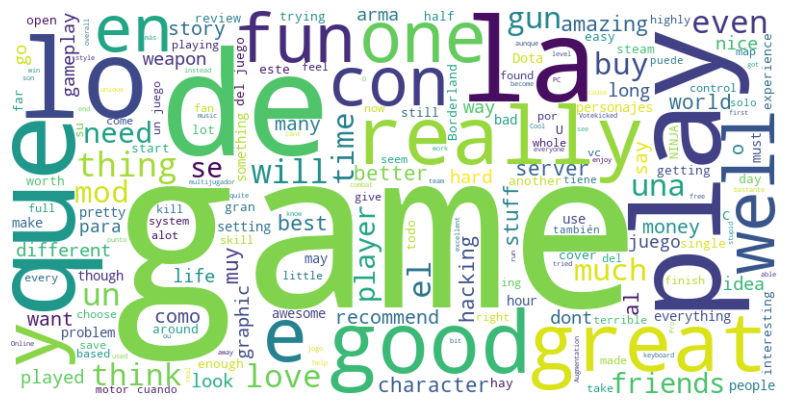

SynapseWidget(Synapse.DataFrame, 2dae2998-e831-4ac0-9850-0b1595be4e5a)

In [48]:
get_recommendations_by_name('counter-strike')

In [49]:
def save_to_pq(dfs, names):

    """
    Saves a DataFrame to a parquet file in a specific directory.
        Parameters:
        - df: DataFrame to save.
        - file_name: Name of the parquet file.
    """
    for df, name in zip(dfs, names):
        archivo = f'/lakehouse/default/Files/Final_data/ML/{name}.parquet'
        pq.write_table(pa.Table.from_pandas(df), archivo)
        print(f"DataFrame '{name}' save as '{archivo}'")

StatementMeta(, ff1aa0d8-7214-4df7-a009-579a680a8ea6, 51, Finished, Available, Finished)

In [50]:
dfs = [df_mf, umatrix_norm, user_sim_df, df_mod_game, game_sim_df,]
# Names corresponding to each DataFrame
names = ['models', 'umatrix_norm','user_sim', 'df_mod_game', 'game_sim']

save_to_pq(dfs, names)

StatementMeta(, ff1aa0d8-7214-4df7-a009-579a680a8ea6, 52, Finished, Available, Finished)

DataFrame 'models' save as '/lakehouse/default/Files/Final_data/ML/models.parquet'
DataFrame 'umatrix_norm' save as '/lakehouse/default/Files/Final_data/ML/umatrix_norm.parquet'
DataFrame 'user_sim' save as '/lakehouse/default/Files/Final_data/ML/user_sim.parquet'
DataFrame 'df_mod_game' save as '/lakehouse/default/Files/Final_data/ML/df_mod_game.parquet'
DataFrame 'game_sim' save as '/lakehouse/default/Files/Final_data/ML/game_sim.parquet'
